In [62]:
from datasets import generate_x_y_data_v1 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [63]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(10, 3, 2)
(10, 3, 2)
(seq_length, batch_size, output_dim)


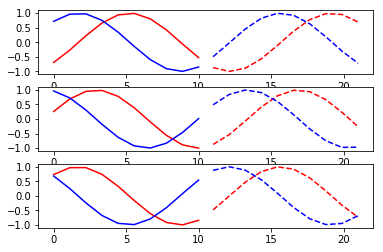

In [64]:
import math

plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
    plt.plot(x_axis+11, sample_y[:, i, 0], 'r--', x_axis+11, sample_y[:, i, 1], 'b--')

plt.show()

In [65]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[1]
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 12  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 1

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 150
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [66]:
test_encoder = Encoder(input_dim, hidden_dim, number_of_layers=layers_stacked_count)

# initialize the hidden state(num_layers, batch_size, hidden_size).
hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))

sample_x, sample_y = generate_data(isTrain=True, batch_size=batch_size)
input_x = autograd.Variable(torch.FloatTensor(sample_x), requires_grad=False)

print(test_encoder)

Encoder (
  (encoder): LSTM(2, 12)
)


In [67]:
encoder_output, encoder_state = test_encoder(input_x,hidden)
print(encoder_output[-1])

Variable containing:

Columns 0 to 9 
 0.1197  0.2801 -0.0751  0.0322 -0.2301  0.1614 -0.0211  0.0453  0.1540 -0.0979
-0.1222 -0.0375 -0.0271  0.1850  0.0606 -0.0119  0.1274  0.0005 -0.1179  0.0410
-0.0855 -0.0280  0.0082  0.1893  0.0251  0.0059  0.1498  0.0045 -0.1185  0.0367
 0.1037  0.2896 -0.0734  0.0320 -0.2252  0.1664 -0.0262  0.0497  0.1608 -0.0964
 0.0583  0.0973  0.0165  0.1463 -0.1060  0.0818  0.1259  0.0329 -0.0496 -0.0265

Columns 10 to 11 
-0.0354 -0.1498
-0.0790 -0.0104
-0.0770 -0.0308
-0.0361 -0.1500
-0.0735 -0.1063
[torch.FloatTensor of size 5x12]



In [68]:
test_decoder = Decoder(hidden_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count)
print(test_decoder)

Decoder (
  (decoder): LSTM(12, 12)
  (linear): Linear (12 -> 2)
)


In [69]:
decoder_input = torch.unsqueeze(encoder_output[-1], 0)
print(decoder_input.size())
decoder_hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))
test_output, decoder_output, (next_ht, next_ct) = test_decoder(decoder_input, decoder_hidden)
print(next_ht.size())
print(next_ct.size())
print(decoder_output.size())
print(test_output)

torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
torch.Size([1, 5, 12])
Variable containing:
-0.0290  0.0122
-0.3590  0.2148
-0.3658 -0.0007
 0.1322 -0.0212
-0.0214  0.3032
[torch.FloatTensor of size 5x2]



In [85]:
class Model(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 output_size,
                 number_of_layers=1,
                 output_length=10):
        super(Model, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, number_of_layers=number_of_layers)
        self.decoder = Decoder(hidden_size, hidden_size, output_size, number_of_layers=number_of_layers)
        self.output_length = output_length
        self.number_of_layers = number_of_layers
        self.hidden_size = hidden_size
        
    def forward(self, x):
        encoder_output, encoder_state = self.encoder(x, None)
        decoder_input = torch.unsqueeze(encoder_output[-1], 0)
        
        seq = []
        next_hidden=None
        next_input = decoder_input
        for _ in range(self.output_length):
            output, next_input, next_hidden = self.decoder(next_input, next_hidden)
            seq += [output]
        return torch.stack(seq, dim=0).squeeze()

In [86]:
model = Model(input_dim, hidden_dim, output_dim)
print(model)
test_output = model(input_x)
print(final_hidden[0].size())
print(test_output.size())

Model (
  (encoder): Encoder (
    (encoder): LSTM(2, 12)
  )
  (decoder): Decoder (
    (decoder): LSTM(12, 12)
    (linear): Linear (12 -> 2)
  )
)
torch.Size([1, 5, 12])
torch.Size([10, 5, 2])


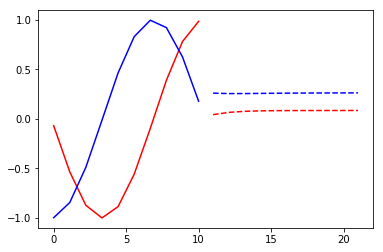

In [87]:
plot_y = test_output.data.numpy()
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
target_x = x_axis+11
plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
plt.show()

In [88]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
next_hidden = None

loss: 0.529494


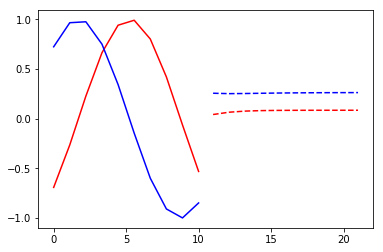

loss: 0.0941207


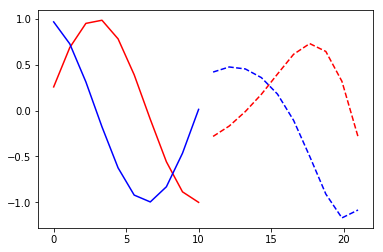

loss: 0.00722135


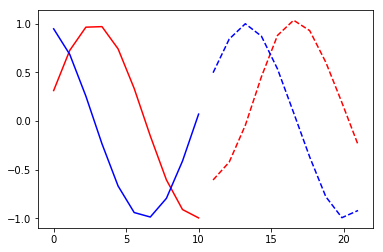

In [90]:
for step in range(nb_iters):
    temp_x, temp_y = generate_data(isTrain=True, batch_size=batch_size)
    x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
    y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
    optimizer.zero_grad()
    prediction = model(x)   # rnn output
    loss = loss_func(prediction, y)
    if step % 50 == 0:
        print('loss:', loss.data.numpy()[0])
        plot_y = prediction.data.numpy()
        plt.figure()
        plt.yticks(np.linspace(-1,1,5))
        plt.plot(x_axis, temp_x[:, i, 0], 'r', x_axis, temp_x[:, i, 1], 'b')
        plt.plot(target_x, plot_y[:, i, 0], 'r--', x_axis+11, plot_y[:, i, 1], 'b--')
        plt.show()
    loss.backward()
    optimizer.step()

In [92]:
temp_x, temp_y = generate_data(isTrain=False, batch_size=1)
x = autograd.Variable(torch.FloatTensor(temp_x), requires_grad=False)
y = autograd.Variable(torch.FloatTensor(temp_y), requires_grad=False)
prediction = model(x)
prediction = prediction.data.numpy()
print(temp_x.shape)
print(prediction.shape)
print(np.sum(temp_y - prediction))

(10, 1, 2)
(10, 2)
0.783513027494


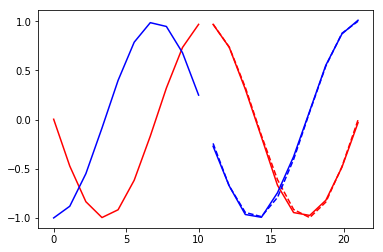

In [97]:
plt.figure()
x_axis = np.linspace(0, 10, 10)
plt.yticks(np.linspace(-1,1,5))
plt.plot(x_axis, temp_x[:, 0, 0], 'r', x_axis, temp_x[:, 0, 1], 'b')
target_x = x_axis+11

plt.plot(target_x, temp_y[:, 0, 0], 'r--', target_x, temp_y[:, 0, 1], 'b--')
plt.plot(target_x, prediction[:, 0], 'r', target_x, prediction[:, 1], 'b')
plt.show()